<a href="https://colab.research.google.com/github/SebastianMM-96/fake-news/blob/main/fakeNewsModels/NLP/NLP_FakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detección de noticias falsas utilizando aprendizaje supervisado y NLP
#### Developed by: Sebastián Marroquín
***

### 1. Importando las librerías necesarias

In [ ]:
# librerías básicas
import numpy as np
import pandas as pd
import itertools
import re
import string
import random
from textblob import TextBlob

# graficación
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

# importando la librería de nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer

# importando scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

### 2. Importando los conjuntos de datos

In [ ]:
print('Importando el conjunto de datos...')
data = pd.read_csv('/content/data/fake_or_real_news.csv')
print('Listo')

Importando el conjunto de datos...
Listo


Inspeccionaremos el dataframe que tiene almacenado nuestro conjunto de datos

In [ ]:
print('Forma del conjunto de datos: {}'.format(data.shape))

Forma del conjunto de datos: (6335, 4)


Inspeccionaremos los elementos que contiene nuestro conjunto de datos

In [ ]:
data.head(10)

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
5,6903,"Tehran, USA","\r\nI’m not an immigrant, but my grandparent...",FAKE
6,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE
7,95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL
8,4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL
9,2909,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL


Corregiremos nuestro conjunto de datos asignando el índice a la primera columna

In [ ]:
data.set_index('Unnamed: 0')

,title,text,label
Unnamed: 0,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...
4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE


Ahora nuestro conjunto de datos se ve de esta forma:

In [ ]:
data.head(10)

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
5,6903,"Tehran, USA","\r\nI’m not an immigrant, but my grandparent...",FAKE
6,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE
7,95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL
8,4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL
9,2909,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL


### 3. Extración de los datos

Guardaremos dentro de una variable la etiqueta de cada una de las noticias

In [ ]:
y = data.label

Ahora que ya tenemos almacenada la columna de "*etiqueta*", podemos eliminar esta columna del dataframe

In [ ]:
data.drop('label', axis=1)

,Unnamed: 0,title,text
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello..."
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T..."
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...
...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene..."


Ahora comenzaremos a crear nuestros conjuntos de entrenamiento y de pruebas utilizando la biblioteca de scikit-learn

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], y, test_size=0.33, random_state=53)

### 4. Clasificación por vectores

#### 4.1 CountVectorizer

In [ ]:
# Inicializamos countVectorizer
count_vec = CountVectorizer(stop_words='english')

# Ajuste y transformacion del conjunto de entrenamiento
count_train = count_vec.fit_transform(X_train)

# Transformacion del conjunto de prueba
count_test = count_vec.transform(X_test)

#### 4.2 Tf-idf Vectorizer

In [ ]:
# Inicializar the tfidf vectorizer
tfidf_vec = TfidfVectorizer(stop_words='english', max_df=0.7)

# Ajustar y transformar el conjunto de entrenamiento
tfidf_train = tfidf_vec.fit_transform(X_train)

# Transformar el conjunto de pruebas
tfidf_test = tfidf_vec.transform(X_test)

#### 4.3 Información obtenida

In [ ]:
print("Tf-idf: {}".format(tfidf_vec.get_feature_names()[-10:]))

Tf-idf: ['حلب', 'عربي', 'عن', 'لم', 'ما', 'محاولات', 'من', 'هذا', 'والمرضى', 'ยงade']


In [ ]:
print("CountVectorizer: {}".format(count_vec.get_feature_names()[-10:]))

CountVectorizer: ['حلب', 'عربي', 'عن', 'لم', 'ما', 'محاولات', 'من', 'هذا', 'والمرضى', 'ยงade']


### 5. Comparación de modelos: Count_Vectorizer vs Tf-idf Vectorizer usando MultiNomial Naïve Bayes

A continuación definiremos una función para gráficar una Matriz de confusión. Esta función se encuentra disponible en el siguiente [link](https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### 5.1 Tf-idf Vectorizer

In [ ]:
# Definiremos el clasificador dentro de una variable
clf_tfidf = MultinomialNB()

Accuracy using Tf-idf: 85.65%
Confusion matrix, without normalization


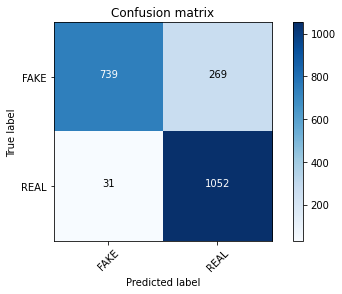

In [ ]:
clf_tfidf.fit(tfidf_train, y_train)
pred_tfidf = clf_tfidf.predict(tfidf_test)
score_tfidf = accuracy_score(y_test, pred_tfidf)

# Obteniendo el puntaje de efectividad
print('Accuracy using Tf-idf: {}%'.format(round(score_tfidf*100,2)))

# Calcular la matriz de confusion
cm_tfidf = confusion_matrix(y_test, pred_tfidf, labels=['FAKE', 'REAL'])

# Graficar
plot_confusion_matrix(cm_tfidf, classes=['FAKE', 'REAL'])

In [ ]:
# Metricas de rendimiento
print(classification_report(y_test, pred_tfidf))

              precision    recall  f1-score   support

        FAKE       0.96      0.73      0.83      1008
        REAL       0.80      0.97      0.88      1083

    accuracy                           0.86      2091
   macro avg       0.88      0.85      0.85      2091
weighted avg       0.88      0.86      0.85      2091



#### 5.2 Count Vectorizer

In [ ]:
# Definiremos el clasificador dentro de una variable
clf_countVec = MultinomialNB()

Accuracy using Tf-idf: 89.34%
Confusion matrix, without normalization


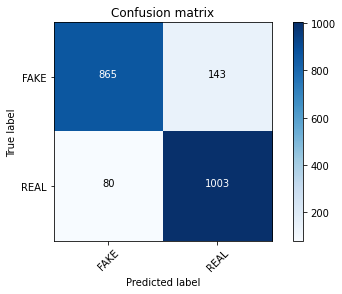

In [ ]:
clf_countVec.fit(count_train, y_train)
pred_countVec = clf_countVec.predict(count_test)
score_countVec = accuracy_score(y_test, pred_countVec)

# Print the accuracy score
print('Accuracy using Tf-idf: {}%'.format(round(score_countVec*100,2)))

# Calculate the confusion matrix
cm_countVec = confusion_matrix(y_test, pred_countVec, labels=['FAKE', 'REAL'])

# Plot the confusion matrix
plot_confusion_matrix(cm_countVec, classes=['FAKE', 'REAL'])

In [ ]:
# Metricas de rendimiento
print(classification_report(y_test, pred_countVec))

              precision    recall  f1-score   support

        FAKE       0.92      0.86      0.89      1008
        REAL       0.88      0.93      0.90      1083

    accuracy                           0.89      2091
   macro avg       0.90      0.89      0.89      2091
weighted avg       0.89      0.89      0.89      2091



### 6. Passive Agressive Classifier